# Edge Impulse - Spectral Features Block Analysis
[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mjrovai/Arduino_Nicla_Vision/blob/main/Motion_Classification/Edge_Impulse_Spectral_Features_Block.ipynb)



# Spectral Features Block
EI Implementation_version >= 2 (Including Wavelets)
- by Marcelo Rovai @ November23


## FFT
### Statistical features (Time Domain) per axis/channel:
After filtering via a Butterworth IIR filter (if enabled), **the mean is subtracted from the signal.** and are calculated:
- RMS
- Skewness
- Kurtosis

### Spectral features (Frequency Domain) per axis/channel:
- Spectral Power
- Skewness
- Kurtosis

### Spectral Power
The filtered signal is passed to the Spectral power section, which computes the **FFT** in order to compute the spectral features.
- The window will be broken into frames (or "sub-windows"), and the FFT is calculated from each frame.
- FFT length determines the number of FFT bins as well as the resolution of frequency peaks that you can separate.
- The total number of Spectral Power features will change, depending on how you set the filter and FFT parameters. With No filtering, the number of features is 1/2 of FFT Length

https://docs.edgeimpulse.com/docs/edge-impulse-studio/processing-blocks/spectral-features

## Wavelets
In case of **Wavelets**, the extracted features are statistical features, crossing features and entropy features (14 per layer):
- `[11] Features`: **n5, n25, n75, n95, mean, median, standard deviation (std), variance (var) and root mean square (rms), kurtosis and skewness (skew)** are calculated.
- `[2] Features`: **Zero crossing rate (zcross) and mean crossing rate (mcross)** are the times that the signal passes through the baseline (y = 0) and the average level (y = u) per unit time respectively
- `[1] Feature`: **Entropy** features are characteristic measure of signal complexity

All above 14 values are calculated for each Layer (including L0, the original signal)

- `[Inputs]`: The **Wavelet Decomposition level** (*1, 2, ...*) and what type of **Wavelet** (*bior1.3, db2, ...*) to use should be defined. If for example, level 1 is chosen, L0 and L1 are used for feature calculation
- The total number of features will change, depending on how you set the filter and the number of layers. For example, with **[None]** filtering, and Level **[1]**, the number of features per axis will  14 x 2 (L0 and L1) = 28. For 6 axis, we will have a total of 168 features.

## Statistical features

## Libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import skew, kurtosis
from scipy import signal
from scipy.signal import welch
from scipy.stats import entropy
from sklearn import preprocessing
import pywt

In [21]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['lines.linewidth'] = 3

## Functions

In [16]:
def plot_data(sensors, axis, title):
    [plt.plot(x, label=y) for x,y in zip(sensors, axis)]
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel('#Sample')
    plt.ylabel('Value')
    plt.box(False)
    plt.grid()
    plt.show()

Clone the public project: https://studio.edgeimpulse.com/public/198358/latest

Get a datasample from accelerometers (2 seconds window; Sample frequency 50Hz)

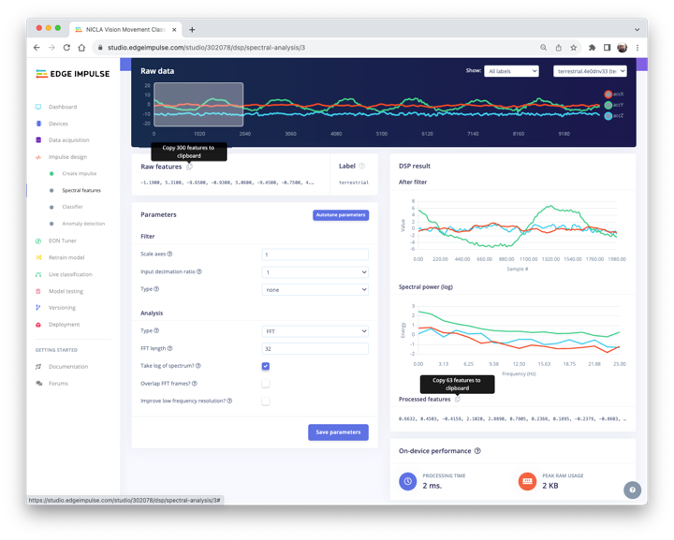

In [7]:
f =  50  # Hertz
wind_sec = 2 # seconds
axis = ['accX', 'accY', 'accZ']
n_sensors = len(axis)
print (f'Frequency = {f}Hz')
print (f'Window = {wind_sec}s')
print (f'No Sensors = {len(axis)}')

Frequency = 50Hz
Window = 2s
No Sensors = 3


In [10]:
data=[-1.1900, 5.3100, -9.6500, -0.9300, 5.0600, -9.4500, -0.7500, 4.4700, -10.1800, -0.6400, 4.1800, -9.7600, -0.6700, 3.7700, -9.9200, -0.3500, 2.4100, -10.2000, -0.0600, 2.0000, -10.3800, -0.2100, 1.8300, -9.7000, -0.0900, 1.8300, -9.3100, -0.3000, 1.5000, -9.1800, -0.4600, 0.4600, -9.9900, -0.4700, -0.8200, -10.7100, -0.3400, -1.6500, -10.6000, -0.1600, -1.8900, -11.2300, -0.3900, -1.9800, -10.3700, -0.3500, -2.3200, -9.4400, -0.6900, -1.9500, -9.0300, -0.7300, -2.2600, -9.6100, -1.1300, -2.6300, -9.9400, -1.2900, -2.5000, -10.3000, -1.3900, -2.7800, -10.2000, -1.3200, -2.9000, -9.6700, -1.1700, -3.2800, -10.4600, -1.1200, -3.2500, -9.7800, -1.0800, -3.3900, -10.1400, -1.0900, -4.0500, -10.2200, -0.8800, -4.2900, -9.6100, 0.0600, -4.1700, -9.6600, 0.4600, -4.8300, -8.7200, 0.5900, -4.1500, -9.3300, 0.3800, -5.0200, -9.1800, 0.3200, -5.1600, -9.7000, 0.3600, -4.9400, -9.2000, 0.4100, -5.2400, -8.9900, 0.5400, -5.3000, -9.3300, 0.7300, -5.0000, -8.8300, 1.0500, -5.3000, -8.8400, 1.2700, -5.5700, -8.8000, 1.1900, -5.0100, -8.3300, 0.9900, -5.0600, -8.7700, 0.7300, -5.1100, -8.3700, 0.3900, -4.5300, -9.0200, 0.3400, -5.1600, -9.4500, 0.2600, -4.7100, -9.8700, 0.2200, -5.4200, -9.9600, 0.2200, -5.0300, -10.5500, 0.3200, -5.1700, -10.3800, 0.4300, -4.7900, -9.8200, 0.2700, -4.0300, -9.6000, 0.1700, -3.6400, -8.8800, -0.1100, -2.9100, -9.4400, -0.7700, -2.0400, -10.5300, -1.0400, -1.6200, -11.0300, -1.0500, -0.9000, -11.3100, -0.9100, -0.1500, -10.5500, -0.8200, 0.7600, -10.6200, -0.5400, 1.4000, -10.1300, -0.4900, 1.7700, -8.9700, -0.5000, 3.1700, -8.4300, -0.4000, 3.5400, -8.6500, -0.7200, 4.5600, -8.8300, -1.0400, 4.8000, -9.1400, -1.3200, 5.4000, -9.4600, -1.3700, 5.7300, -9.3200, -1.6100, 6.3500, -9.1400, -1.4800, 6.2400, -8.8200, -1.3500, 6.6100, -8.8800, -1.1000, 6.3100, -8.3700, -0.8900, 5.6600, -8.8300, -0.4500, 5.5400, -9.6500, -0.5100, 5.3500, -9.1800, -0.3800, 5.1500, -8.9900, -0.4000, 5.3900, -8.5900, -0.5300, 5.0300, -8.9000, -0.8100, 5.3200, -9.7100, -0.6400, 5.0700, -9.7100, -0.8500, 5.4200, -10.1200, -0.5900, 4.8000, -8.6200, -0.7300, 4.9100, -8.4600, -0.5900, 4.5400, -9.0600, -0.6500, 4.7800, -8.8200, -0.7700, 3.3500, -9.6700, -0.6700, 2.7700, -10.3500, -0.3200, 1.8700, -10.0200, 0.0300, 1.4500, -10.1700, 0.1700, 0.6400, -9.3500, 0.0800, -0.1200, -10.1300, -0.0600, -0.4200, -10.7800, -0.1100, -0.2500, -10.1700, -0.1800, -1.1300, -9.7500, -0.4000, -0.6500, -10.4900, -0.5400, -1.3700, -10.3800, -0.6900, -1.5200, -9.8500, -0.6900, -1.8900, -10.1600, -1.1000, -1.6800, -10.4100, -1.4000, -1.9400, -10.4000, -1.4200, -2.4200, -10.9700, -1.2900, -1.7300, -11.2100, -1.4300, -2.2900, -10.2700, -1.4300, -2.6100, -11.2800]
No_raw_features = len(data)
N = int(No_raw_features/n_sensors)
print (f"No. raw features: {No_raw_features}; N= {N} (number of raw features per axix)")

No. raw features: 300; N= 100 (number of raw features per axix)


In [12]:
# Processed Features
features = [0.6632, 0.4503, -0.4159, 2.1020, 2.8890, 0.7905, 0.2368, 0.1895, -0.2379, -0.8603, -0.6737, -1.0428, -1.3921, -1.0518, -1.1825, -1.4258, -1.4079, -1.3015, -1.1551, -1.8159, -1.1764, 3.8977, 0.2576, -1.3604, 2.7238, 6.1093, 2.2040, 1.4922, 1.1805, 0.9606, 0.6535, 0.4624, 0.3886, 0.3895, 0.2671, 0.3216, 0.1582, 0.1726, 0.2914, -0.0520, -0.1834, 0.3010, 0.7339, -0.1457, -0.7303, 1.9611, 2.8542, 0.6575, -0.2070, 0.5096, 0.1165, 0.1760, -0.8151, -0.8245, -0.4456, -0.4477, -0.9939, -0.8784, -0.4879, -0.9253, -0.5177, -1.2234, -1.3113]
N_feat = len(features)
N_feat_axis = int(N_feat/n_sensors)
print (f"No. features: {N_feat}; N_feat_axis= {N_feat_axis} (number of pre-processed features per axix)")

No. features: 63; N_feat_axis= 21 (number of pre-processed features per axix)


In [49]:
print(f' - Total Number of features without filtering: {N_feat}')
print(f' - Total Number of Statistical processed features : {3*n_sensors}')
print(f' - Total Number of Spectral processsed features : {N_feat-3*n_sensors}')
print(f' - Number of Processed features per axis: {N_feat_axis}')

 - Total Number of features without filtering: 63
 - Total Number of Statistical processed features : 9
 - Total Number of Spectral processsed features : 54
 - Number of Processed features per axis: 21


- 3 Statistical features (time) per axis -->  Total: 9 features
- 16 Spectral Power Features (Freq) per axis --> Total: 48 features
- 2 Spectral Skew/Kurtosis (freq) per axis -> Total: 6 features
- Total Processed Features = 9+48+6 = 63

Features per axix: `[rms] [skew] [kurtosis] [spectral skew] [spectral kurtosis] [Spectral Power 1] ... [Spectral Power 16]`

### Split raw data per sensor

In [14]:
accX = data[0::3]
accY = data[1::3]
accZ = data[2::3]
sensors = [accX, accY, accZ]

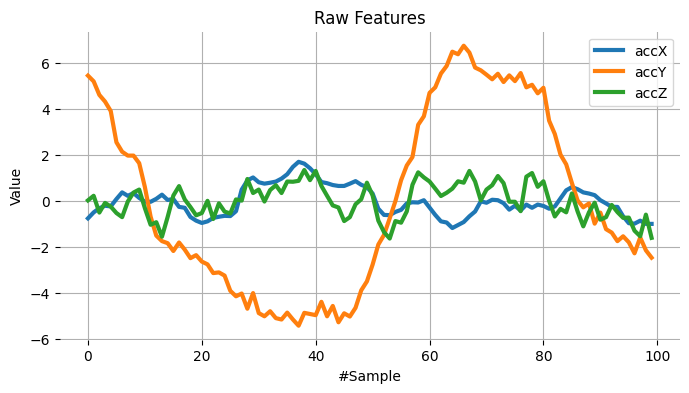

In [22]:
plot_data(sensors, axis, 'Raw Features')

### Subtrating the mean from data
Subtracting the mean from a set of data is a common data pre-processing step in statistics and machine learning. The purpose of subtracting the mean from data is to center the data around zero. This is important because it can reveal patterns and relationships that might be hidden if the data is not centered.

Here are some specific reasons why subtracting the mean can be useful:

- It simplifies analysis: By centering the data, the mean becomes zero, which can make some calculations simpler and easier to interpret.
- It removes bias: If the data has a bias, subtracting the mean can remove that bias and allow for more accurate analysis.
- It can reveal patterns: Centering the data can help reveal patterns that might be hidden if the data is not centered. For example, if you are analyzing a time series dataset, centering the data can help you identify trends over time.
- It can improve performance: In some machine learning algorithms, centering the data can improve performance by reducing the influence of outliers and making the data more easily comparable.
Overall, subtracting the mean is a simple but powerful technique that can be used to improve the analysis and interpretation of data.

In [18]:
dtmean = [(sum(x)/len(x)) for x in sensors]
[print('mean_'+x+'= ', round(y, 4)) for x,y in zip(axis, dtmean)][0]

mean_accX=  -0.4441
mean_accY=  -0.1542
mean_accZ=  -9.6868


In [19]:
accX = [(x - dtmean[0]) for x in accX]
accY = [(x - dtmean[1]) for x in accY]
accZ = [(x - dtmean[2]) for x in accZ]
sensors = [accX, accY, accZ]

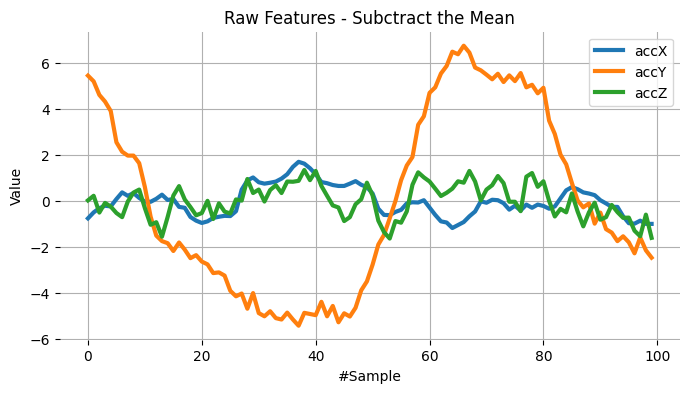

In [23]:
plot_data(sensors, axis, 'Raw Features - Subctract the Mean')

### RMS Calculation

The RMS value of a set of values (or a continuous-time waveform) is the square root of the arithmetic mean of the squares of the values, or the square of the function that defines the continuous waveform. In physics, the RMS current value can also be defined as the "value of the direct current that dissipates the same power in a resistor."

In the case of a set of n values $\{x_{1},x_{2},\dots ,x_{n}\}$, the RMS is:

$\displaystyle x_{\text{RMS}}={\sqrt {{\frac {1}{n}}\left(x_{1}^{2}+x_{2}^{2}+\cdots +x_{n}^{2}\right)}}.$

`NOTE that the RMS value is different for original raw data and after subtracting the mean`

In [24]:
# Using numpy and standartized data (subtracting mean)
rms = [np.sqrt(np.mean(np.square(x))) for x in sensors]
[print('rms_'+x+'= ', round(y, 4)) for x,y in zip(axis, rms)][0]

rms_accX=  0.6632
rms_accY=  3.8977
rms_accZ=  0.7339


In [25]:
# Compare with Edge Impulse result features
features[0:N_feat:N_feat_axis]

[0.6632, 3.8977, 0.7339]

### Skewness and kurtosis calculation

In statistics, skewness and kurtosis are two ways to measure the **shape of a distribution**.

[**Skewness**](https://en.wikipedia.org/wiki/Skewness) is a measure of the asymmetry of a distribution. This value can be positive or negative.
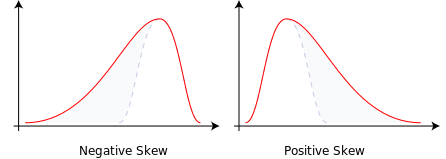
- A negative skew indicates that the tail is on the left side of the distribution, which extends towards more negative values.
- A positive skew indicates that the tail is on the right side of the distribution, which extends towards more positive values.
- A value of zero indicates that there is no skewness in the distribution at all, meaning the distribution is perfectly symmetrical.

[**Kurtosis**](https://en.wikipedia.org/wiki/Kurtosis) is a measure of whether or not a distribution is heavy-tailed or light-tailed relative to a normal distribution.

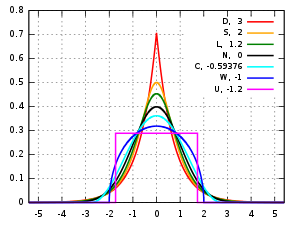
- The kurtosis of a normal distribution is 0.
- If a given distribution has a kurtosis is negative, it is said to be playkurtic, which means it tends to produce fewer and less extreme outliers than the normal distribution.
- If a given distribution has a kurtosis positive, it is said to be leptokurtic, which means it tends to produce more outliers than the normal distribution.

`NOTE that the Skewness and Kurtosis values are the same for original raw data and after subtracting the mean`

Let's see the data distribution and the Skewness and kurtosis calculation

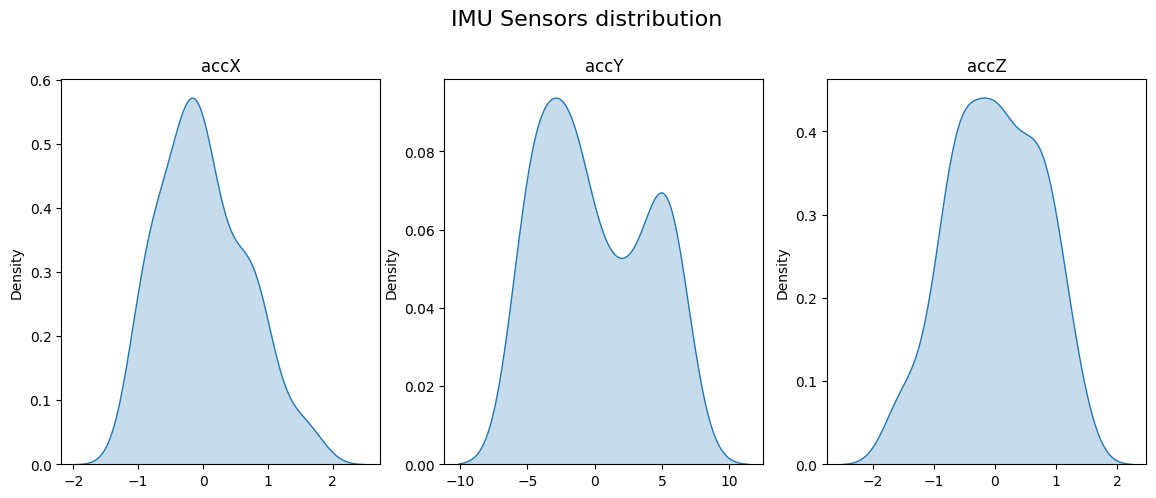

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))
sns.kdeplot(accX, fill=True, ax=axes[0])
sns.kdeplot(accY, fill=True, ax=axes[1])
sns.kdeplot(accZ, fill=True, ax=axes[2])
axes[0].set_title('accX')
axes[1].set_title('accY')
axes[2].set_title('accZ')
plt.suptitle('IMU Sensors distribution', fontsize=16, y=1.02)
plt.show()

In [28]:
skew = [skew(x, bias=False) for x in sensors]
[print('skew_'+x+'= ', round(y, 4)) for x,y in zip(axis, skew)][0]

skew_accX=  0.4572
skew_accY=  0.2616
skew_accZ=  -0.1479


In [29]:
# Compare with Edge Impulse result features
features[1:N_feat:N_feat_axis]

[0.4503, 0.2576, -0.1457]

In [30]:
kurt = [kurtosis(x, bias=False) for x in sensors]
[print('kurt_'+x+'= ', round(y, 4)) for x,y in zip(axis, kurt)][0]

kurt_accX=  -0.3749
kurt_accY=  -1.3685
kurt_accZ=  -0.7057


In [31]:
# Compare with Edge Impulse result features
features[2:N_feat:N_feat_axis]

[-0.4159, -1.3604, -0.7303]

## Spectral features

In [32]:
FFT_Lenght = 32
fs = f
print (f"Sample Frequency: {f}Hz")

Sample Frequency: 50Hz


Once the sampled window usually is larger than the FFT size, the window will be broken into frames (or "sub-windows"), and the FFT is calculated from each frame.

**FFT length** - The FFT size. This determines the number of FFT bins as well as the resolution of frequency peaks that you can separate. A lower number means more signals will average together in the same FFT bin, but also reduces the number of features and model size. A higher number will separate more signals into separate bins, but generates a larger model.

### Spectral Power - Welch’s method
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html

To split the signal on frequency domain in bins and calculate the power spectrum for each bin, we should use a method called **Welch’s method**.

This method divides the signal into overlapping segments, applies a window function to each segment, computes the periodogram of each segment using DFT, and averages them to obtain a smoother estimate of the power spectrum.

In [33]:
# Function used by Edge Impulse insteady scipy.signal.welch().
def welch_max_hold(fx, sampling_freq, nfft, n_overlap):
    n_overlap = int(n_overlap)
    spec_powers = [0 for _ in range(nfft//2+1)]
    ix = 0
    while ix <= len(fx):
        # Slicing truncates if end_idx > len, and rfft will auto zero pad
        fft_out = np.abs(np.fft.rfft(fx[ix:ix+nfft], nfft))
        spec_powers = np.maximum(spec_powers, fft_out**2/nfft)
        ix = ix + (nfft-n_overlap)
    return np.fft.rfftfreq(nfft, 1/sampling_freq), spec_powers

In [34]:
fax,Pax = welch_max_hold(accX, fs, FFT_Lenght, 0)
fay,Pay = welch_max_hold(accY, fs, FFT_Lenght, 0)
faz,Paz = welch_max_hold(accZ, fs, FFT_Lenght, 0)

In [35]:
specs = [Pax, Pay, Paz ]

Note that since we subtract the mean at the begining, bin 0 (DC) will always be ~0, so we skip it (p[1:])



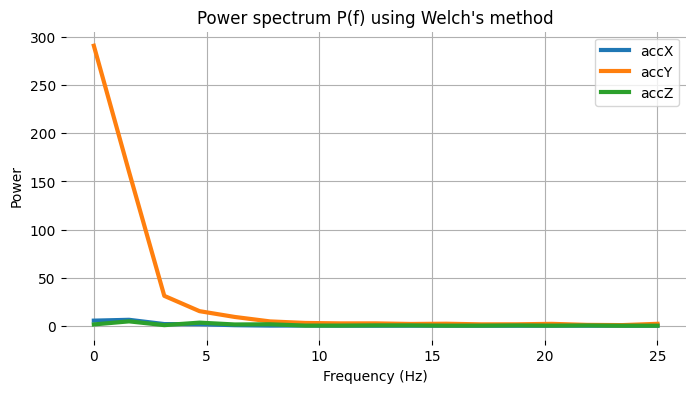

In [36]:
# Plot power spectrum versus frequency
# Since we subtract the mean at the begining, bin 0 (DC) will always be ~0, so skip it
plt.plot(fax,Pax, label='accX')
plt.plot(fay,Pay, label='accY')
plt.plot(faz,Paz, label='accZ')

plt.legend(loc='upper right')
plt.xlabel('Frequency (Hz)')
#plt.ylabel('PSD [V**2/Hz]')
plt.ylabel('Power')
plt.title('Power spectrum P(f) using Welch\'s method')
plt.grid()
plt.box(False)
plt.show()

In [37]:
print("\nCalculated Spectral Power features for accX:")
[print(round(x, 4)) for x in Pax[1:]][0]


Calculated Spectral Power features for accX:
6.1729
1.7252
1.5471
0.5783
0.1379
0.212
0.0906
0.0405
0.0888
0.0657
0.0375
0.0391
0.0499
0.07
0.0153
0.0666


In [38]:
print("\nCalculated Spectral Power features for accY:")
[print(round(x, 4)) for x in Pay[1:]][0]


Calculated Spectral Power features for accY:
159.9539
31.0592
15.1541
9.1322
4.5026
2.9003
2.447
2.4519
1.8498
2.0969
1.4396
1.4881
1.9562
0.8871
0.6555
2.0


In [39]:
print("\nCalculated Spextral Power features for accZ:")
[print(round(x, 4)) for x in Paz[1:]][0]


Calculated Spextral Power features for accZ:
4.5446
0.6209
3.2326
1.3077
1.4997
0.1531
0.1498
0.3585
0.3567
0.1014
0.1323
0.3251
0.1188
0.3036
0.0598
0.0488


### Spectral Skewness and Kurtosis

`If you got an error, import the libraries again`

In [42]:
spec_skew = [skew(x, bias=False) for x in specs]
[print('spectral_skew_'+x+'= ', round(y, 4)) for x,y in zip(axis, spec_skew)][0]

spectral_skew_accX=  2.3112
spectral_skew_accY=  2.9948
spectral_skew_accZ=  2.1562


In [43]:
spec_kurtosis = [kurtosis(x, bias=False) for x in specs]
[print('spectral_kurtosis_'+x+'= ', round(y, 4)) for x,y in zip(axis, spec_kurtosis)][0]

spectral_kurtosis_accX=  4.4192
spectral_kurtosis_accY=  8.8356
spectral_kurtosis_accZ=  4.3714


### List Spectral features per axis and compare with EI

In [44]:
print("EI Processed Spectral features (accX): ")
print(features[3:N_feat_axis][0:])
print("\nCalculated features:")
print (round(spec_skew[0],4))
print (round(spec_kurtosis[0],4))
[print(round(x, 4)) for x in Pax[1:]][0]

EI Processed Spectral features (accX): 
[2.102, 2.889, 0.7905, 0.2368, 0.1895, -0.2379, -0.8603, -0.6737, -1.0428, -1.3921, -1.0518, -1.1825, -1.4258, -1.4079, -1.3015, -1.1551, -1.8159, -1.1764]

Calculated features:
2.3112
4.4192
6.1729
1.7252
1.5471
0.5783
0.1379
0.212
0.0906
0.0405
0.0888
0.0657
0.0375
0.0391
0.0499
0.07
0.0153
0.0666


In [45]:
print("EI Processed Spectral features (accY): ")
print(features[16:26][0:]) #13: 3+N_feat_axis;  26 = 2x N_feat_axis
print("\nCalculated features:")
print (round(spec_skew[1],4))
print (round(spec_kurtosis[1],4))
[print(round(x, 4)) for x in Pay[1:]][0]

EI Processed Spectral features (accY): 
[-1.4079, -1.3015, -1.1551, -1.8159, -1.1764, 3.8977, 0.2576, -1.3604, 2.7238, 6.1093]

Calculated features:
2.9948
8.8356
159.9539
31.0592
15.1541
9.1322
4.5026
2.9003
2.447
2.4519
1.8498
2.0969
1.4396
1.4881
1.9562
0.8871
0.6555
2.0


In [46]:
print("EI Processed Spectral features (accZ): ")
print(features[29:][0:]) #29: 3+(2*N_feat_axis);
print("\nCalculated features:")
print (round(spec_skew[2],4))
print (round(spec_kurtosis[2],4))
[print(round(x, 4)) for x in Paz[1:]][0]

EI Processed Spectral features (accZ): 
[0.9606, 0.6535, 0.4624, 0.3886, 0.3895, 0.2671, 0.3216, 0.1582, 0.1726, 0.2914, -0.052, -0.1834, 0.301, 0.7339, -0.1457, -0.7303, 1.9611, 2.8542, 0.6575, -0.207, 0.5096, 0.1165, 0.176, -0.8151, -0.8245, -0.4456, -0.4477, -0.9939, -0.8784, -0.4879, -0.9253, -0.5177, -1.2234, -1.3113]

Calculated features:
2.1562
4.3714
4.5446
0.6209
3.2326
1.3077
1.4997
0.1531
0.1498
0.3585
0.3567
0.1014
0.1323
0.3251
0.1188
0.3036
0.0598
0.0488


# Wavelets

[Wavelet](https://en.wikipedia.org/wiki/Wavelet) is a powerful technique that is especially useful for analyzing signals with transient features or abrupt changes, such as spikes or edges, which are difficult to analyze with traditional Fourier-based techniques.

Wavelet transforms work by breaking down a signal into different frequency components and analyzing them individually. The transformation is achieved by **convolving the signal with a wavelet function**, which is a small waveform that is centered at a specific time and frequency. This process effectively decomposes the signal into different frequency bands, each of which can be analyzed separately.

One of the key benefits of wavelet transforms is that they allow for time-frequency analysis, which means that they can reveal the frequency content of a signal as it changes over time. This makes them particularly useful for analyzing non-stationary signals, which vary over time.

Wavelets have many practical applications, including signal and image compression, denoising, feature extraction, and image processing.

Let's select Wavelet on Spectral Features block


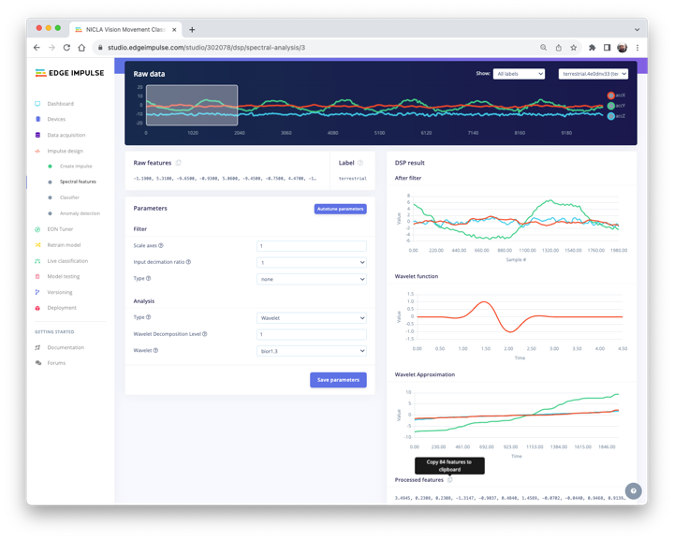

### The Wavelet Fuction

In [52]:
wavelet_name='bior1.3'
num_layer = 1

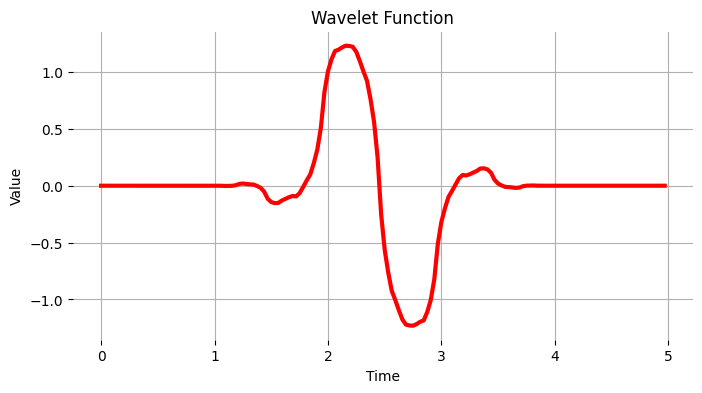

In [53]:
wavelet = pywt.Wavelet(wavelet_name)
[phi_d,psi_d,phi_r,psi_r,x] = wavelet.wavefun(level=5)
plt.plot(x, psi_d, color='red')
plt.title('Wavelet Function')
plt.ylabel('Value')
plt.xlabel('Time')
plt.grid()
plt.box(False)
plt.show()

### Processed Features

In [54]:
features = [3.4945, 0.2308, 0.2308, -1.3147, -0.9037, 0.4840, 1.4589, -0.0702, -0.0440, 0.9468, 0.9139, 0.9478, 0.4957, -0.3714, 3.3498, 0.3846, 0.4231, -0.2263, -0.0919, 0.0707, 0.2121, 0.0000, -0.0203, 0.1644, 0.0275, 0.1656, -0.6228, 3.8308, 3.5465, 0.0577, 0.0577, -7.0192, -4.3516, 6.0137, 8.1191, -1.2554, 0.0843, 5.5254, 31.1291, 5.5261, 0.2492, -1.3873, 3.3778, 0.2692, 0.2692, -0.4879, -0.2263, 0.2333, 0.6364, 0.1414, 0.0804, 0.3776, 0.1454, 0.3861, 0.3307, -0.0100, 3.5845, 0.2500, 0.2885, -1.6494, -0.7001, 0.7485, 1.5184, 0.0326, -0.0291, 0.9982, 1.0159, 0.9986, -0.1343, -0.7463, 3.5679, 0.5000, 0.5192, -0.6576, -0.2970, 0.3111, 0.5798, 0.0495, 0.0105, 0.4111, 0.1723, 0.4113, -0.3830, -0.4196]
N_feat = len(features)
N_feat_axis = int(N_feat/n_sensors)

In [55]:
print(f' - Total Number of features without filtering: {N_feat}')
print(f' - Total Number of features per layer: {int(N_feat/(num_layer+1))}')
print(f' - Total Number of features per axis per layer: {N_feat_axis}')

 - Total Number of features without filtering: 84
 - Total Number of features per layer: 42
 - Total Number of features per axis per layer: 28


It is possible to calculate the maximum number of Wavelet decomposition levels.

In [56]:
pywt.dwt_max_level(len(accX), wavelet_name)

4

### Wavelet Analysis
Wavelet analysis decomposes a signal (**accX, accY and accZ**) into different frequency components using a set of filters applied to the signal, which separates these components into low-frequency (slowly varying parts of the signal containing long-term patterns), here **accX_l1, accY_l1, accZ_l1** and, high-frequency (rapidly varying parts of the signal containing short-term patterns) components, here **accX_d1, accY_d1, accZ_d1**,  allowing for the extraction of features for further analysis or classification. Only the low frequency components will be used. In this example we are assuming only one level (Single level Discrete Wavelet Transform), where the function will return a tupple. With a multilevel decomposition, the "Multilevel 1D Discrete Wavelet Transform", the result will be a list. [Discrete Wavelet Transform (DWT)](https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html)

In [57]:
(accX_l1, accX_d1) = pywt.dwt(accX, wavelet_name)
(accY_l1, accY_d1) = pywt.dwt(accY, wavelet_name)
(accZ_l1, accZ_d1) = pywt.dwt(accZ, wavelet_name)
sensors_l1 = [accX_l1, accY_l1, accZ_l1]

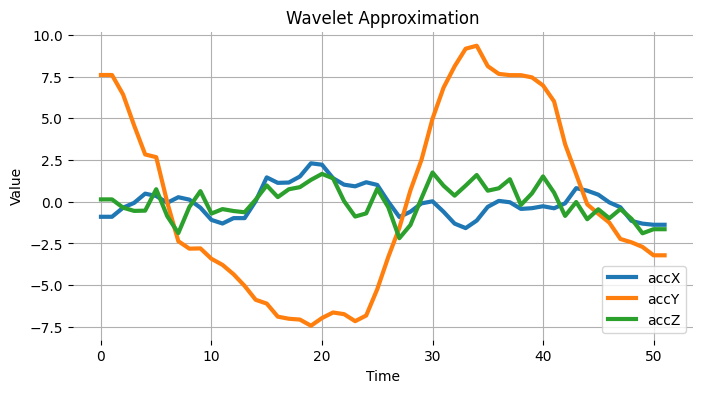

In [58]:
# Plot power spectrum versus frequency
# Since we subtract the mean at the begining, bin 0 (DC) will always be ~0, so skip it
plt.plot(accX_l1, label='accX')
plt.plot(accY_l1, label='accY')
plt.plot(accZ_l1, label='accZ')
plt.legend(loc='lower right')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Wavelet Approximation')
plt.grid()
plt.box(False)
plt.show()

##  Feature Extraction

### Basic Statistical Features

In [59]:
def calculate_statistics(signal):
    n5 = np.percentile(signal, 5)
    n25 = np.percentile(signal, 25)
    n75 = np.percentile(signal, 75)
    n95 = np.percentile(signal, 95)
    median = np.percentile(signal, 50)
    mean = np.mean(signal)
    std = np.std(signal)
    var = np.var(signal)
    rms = np.sqrt(np.mean(np.square(signal)))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

In [60]:
stat_feat_l0 = [calculate_statistics(x) for x in sensors]
stat_feat_l1 = [calculate_statistics(x) for x in sensors_l1]

In [61]:
print (f"feat_l0 or l_1 has {len(stat_feat_l0[0])} statistical features for each of the {len(stat_feat_l0)} axis")

feat_l0 or l_1 has 9 statistical features for each of the 3 axis


In [62]:
skew_l0 = [skew(x, bias=False) for x in sensors]
skew_l1 = [skew(x, bias=False) for x in sensors_l1]
kurtosis_l0 = [kurtosis(x, bias=False) for x in sensors]
kurtosis_l1 = [kurtosis(x, bias=False) for x in sensors_l1]

### Crossings
**Zero crossing (zcross)** is the number of times the wavelet coefficient crosses the zero axis. It can be used as a measure of the frequency content of the signal since high-frequency signals tend to have more zero crossings than low-frequency signals.

**Mean crossing (mcross)**, on the other hand, is the number of times the wavelet coefficient crosses the mean of the signal. It can be used as a measure of the amplitude of the signal since high-amplitude signals tend to have more mean crossings than low-amplitude signals.

In [63]:
def getZeroCrossingRate(arr):
    my_array = np.array(arr)
    zcross = float("{0:.2f}".format((((my_array[:-1] * my_array[1:]) < 0).sum())/len(arr)))
    return zcross

def getMeanCrossingRate(arr):
    mcross = getZeroCrossingRate(np.array(arr) - np.mean(arr))
    return mcross

In [64]:
def calculate_crossings(list):
    zcross=[]
    mcross=[]
    for i in range(len(list)):
        zcross_i = getZeroCrossingRate(list[i])
        zcross.append(zcross_i)
        mcross_i = getMeanCrossingRate(list[i])
        mcross.append(mcross_i)
    return zcross, mcross

In [65]:
calculate_crossings(sensors_l1)

([0.23, 0.06, 0.25], [0.23, 0.06, 0.29])

In [66]:
cross_l0 = calculate_crossings(sensors)
cross_l1 = calculate_crossings(sensors_l1)

### Entropy
In wavelet analysis, entropy refers to the degree of disorder or randomness in the distribution of wavelet coefficients. Here we used Shannon entropy, that is a measure of the amount of uncertainty or randomness in a signal. It is calculated as the negative sum of the probabilities of the different possible outcomes of the signal multiplied by their logarithm base 2. In the context of wavelet analysis, Shannon entropy can be used to measure the complexity of the signal, with higher values indicating greater complexity.

In [67]:
def calculate_entropy(signal, base=None):
    value, counts = np.unique(signal, return_counts=True)
    return entropy(counts, base=base)

In [68]:
entropy_l0 = [calculate_entropy(x) for x in sensors]
entropy_l1 = [calculate_entropy(x) for x in sensors_l1]

### List all weavelets features and create a list by layers

In [69]:
L1_features_names = ["L1-n5", "L1-n25", "L1-n75", "L1-n95", "L1-median", "L1-mean", "L1-std", "L1-var", "L1-rms", "L1-skew", "L1-Kurtosis", "L1-zcross", "L1-mcross", "L1-entropy"]
L0_features_names = ["L0-n5", "L0-n25", "L0-n75", "L0-n95", "L0-median", "L0-mean", "L0-std", "L0-var", "L0-rms", "L0-skew", "L0-Kurtosis", "L0-zcross", "L0-mcross", "L0-entropy"]

In [70]:
len(L1_features_names)

14

In [71]:
all_feat_l0 = []
for i in range(len(axis)):
    feat_l0 = stat_feat_l0[i]+[skew_l0[i]]+[kurtosis_l0[i]]+[cross_l0[0][i]]+[cross_l0[1][i]]+[entropy_l0[i]]
    [print(axis[i]+' '+x+'= ', round(y, 4)) for x,y in zip(L0_features_names, feat_l0)][0]
    all_feat_l0.append(feat_l0)
all_feat_l0 = [item for sublist in all_feat_l0 for item in sublist]
print(f"\nAll L0 Features = {len(all_feat_l0)}")

accX L0-n5=  -0.9569
accX L0-n25=  -0.4709
accX L0-n75=  0.4816
accX L0-n95=  1.1741
accX L0-median=  -0.0759
accX L0-mean=  0.0
accX L0-std=  0.6632
accX L0-var=  0.4399
accX L0-rms=  0.6632
accX L0-skew=  0.4572
accX L0-Kurtosis=  -0.3749
accX L0-zcross=  0.12
accX L0-mcross=  0.12
accX L0-entropy=  4.2897
accY L0-n5=  -5.0193
accY L0-n25=  -3.2983
accY L0-n75=  4.0267
accY L0-n95=  5.8177
accY L0-median=  -1.0958
accY L0-mean=  0.0
accY L0-std=  3.8977
accY L0-var=  15.1924
accY L0-rms=  3.8977
accY L0-skew=  0.2616
accY L0-Kurtosis=  -1.3685
accY L0-zcross=  0.03
accY L0-mcross=  0.03
accY L0-entropy=  4.5359
accZ L0-n5=  -1.2862
accZ L0-n25=  -0.5182
accZ L0-n75=  0.6343
accZ L0-n95=  1.1033
accZ L0-median=  0.0018
accZ L0-mean=  -0.0
accZ L0-std=  0.7339
accZ L0-var=  0.5386
accZ L0-rms=  0.7339
accZ L0-skew=  -0.1479
accZ L0-Kurtosis=  -0.7057
accZ L0-zcross=  0.19
accZ L0-mcross=  0.19
accZ L0-entropy=  4.2706

All L0 Features = 42


In [72]:
all_feat_l1 = []
for i in range(len(axis)):
    feat_l1 = stat_feat_l1[i]+[skew_l1[i]]+[kurtosis_l1[i]]+[cross_l1[0][i]]+[cross_l1[1][i]]+[entropy_l1[i]]
    [print(axis[i]+' '+x+'= ', round(y, 4)) for x,y in zip(L1_features_names, feat_l1)][0]
    all_feat_l1.append(feat_l1)
all_feat_l1 = [item for sublist in all_feat_l1 for item in sublist]
print(f"\nAll L1 Features = {len(all_feat_l1)}")

accX L1-n5=  -1.3454
accX L1-n25=  -0.9037
accX L1-n75=  0.5282
accX L1-n95=  1.4824
accX L1-median=  -0.0826
accX L1-mean=  -0.044
accX L1-std=  0.9468
accX L1-var=  0.8963
accX L1-rms=  0.9478
accX L1-skew=  0.5105
accX L1-Kurtosis=  -0.2849
accX L1-zcross=  0.23
accX L1-mcross=  0.23
accX L1-entropy=  3.8979
accY L1-n5=  -7.041
accY L1-n25=  -4.5264
accY L1-n75=  6.1184
accY L1-n95=  8.1235
accY L1-median=  -1.4114
accY L1-mean=  0.0843
accY L1-std=  5.5254
accY L1-var=  30.5305
accY L1-rms=  5.5261
accY L1-skew=  0.2566
accY L1-Kurtosis=  -1.4056
accY L1-zcross=  0.06
accY L1-mcross=  0.06
accY L1-entropy=  3.9246
accZ L1-n5=  -1.7544
accZ L1-n25=  -0.7028
accZ L1-n75=  0.7558
accZ L1-n95=  1.5562
accZ L1-median=  0.0078
accZ L1-mean=  -0.0291
accZ L1-std=  0.9982
accZ L1-var=  0.9963
accZ L1-rms=  0.9986
accZ L1-skew=  -0.1384
accZ L1-Kurtosis=  -0.6985
accZ L1-zcross=  0.25
accZ L1-mcross=  0.29
accZ L1-entropy=  3.8979

All L1 Features = 42


In [73]:
feat = all_feat_l0+all_feat_l1
len(feat)

84